In [6]:
%matplotlib ipympl
import numpy as np
from numpy.fft import  ifft2, ifftshift
from numpy.random import default_rng as randn
#from scipy.special import kv as beselk
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
from ows import ows
import time

rad2asec = 3600 * 180/np.pi
asec2rad = 1/rad2asec

## PSD
Power spectrum density

In [7]:
start = time.time()
# Input

dimmat = 128
dxp = 0.03222887597610881 # Pupil plane pixel size
r0 = .1
L0 = -1
D = 0.01
wl = 500e-9 # [m]

# Computing limit values
FoV = 25*asec2rad # arcsec
#Npx = 1000 # image plane pixels qty
#Daf = asec2rad*FoV#/Npx # [rad/px]  (Numerical aperture)
Daf = wl/(2*D) # max
dfp = Daf/wl # [/m] Pupil plane spatial frequency pixel size (Numerical aperture/WL)
dimpsf = 8*wl*np.sqrt((D/r0)**2 + 1)/(Daf*D)   # (min psf size) Matrix size
print("Miminum matrix dimention :",dimpsf)
# dimmat = int(dimpsf)+int((dimpsf %1 !=0)*1)
# dimmat += int((dimmat %2 != 0)*1)

if dimmat < dimpsf:
    print(f"dimmat is too small: {dimmat:d}. It souhld be greater than {dimpsf:.1f}")


PSD = ows.psd(dimmat, dxp, r0, wl)
# plt.close(1)
# plt.figure(1)
# plt.imshow(PSD**(1/8))
# plt.title("Phase spectrum density ^(1/8)")
# plt.colorbar()

Miminum matrix dimention : 16.079800993793423


## Phase screen & PSF

In [ ]:
SEED = 1



[phase_screen, psf, pupil_mask, R] = ows.phase_screen(PSD, dxp, SEED, PUPIL = True)


# plt.close(4)
# plt.figure(4)
# plt.imshow(phase_screen.real)
# plt.title("phase screen")
# plt.colorbar()

# plt.show()
# plt.close(5)
# plt.figure(5)
# plt.imshow((np.abs(psf)**(1/2)))
# plt.title("PSF^(1/2)")
# plt.colorbar()
# plt.show()


# Lenslet illumination mask

In [9]:
from astropy.io import fits

def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# phase_screen_normilized = normalize(phase_screen)
# psf_normalized = normalize(psf)

# fits.writeto('data/phase_screen.fits', phase_screen, overwrite=True)
# fits.writeto('data/phase_screen_normalized.fits', phase_screen_normilized, overwrite=True)
# fits.writeto('data/psf.fits', psf, overwrite=True)
# fits.writeto('data/psf_normalized.fits', psf_normalized, overwrite=True)

# input_infos = f"ro,{r0:f},m\nWL,{wl:g},m\ndxp,{dxp:f},\nseed,{1},"
# with open('data/inputs.txt', 'w') as f:
#     f.write(input_infos)

# Lenslet array illumination

# Wavefront slope

1. Simulating the lenslet array


???
$$W_f= PH\star L$$

???

2. Compute the spot centers

$$x_{c,k} = \frac{\sum_{i\in k}\sum_{j\in k} x_{i,j}I_{i,j}}{\sum_{i\in k}\sum_{j\in k} I_{i,j}}$$

$$y_{c,k} = \frac{\sum_{i\in k}\sum_{j \in k} y_{i,j}I_{i,j}}{\sum_{i\in k}\sum_{j\in k} I_{i,j}}$$

3. Extract the WF slopes

$$ \begin{bmatrix}\partial w /\partial x \\ \partial w/\partial y\end{bmatrix}_k = \begin{bmatrix} \beta_x\\\beta_y \end{bmatrix}_k \approx \frac{1}{L_H}\begin{bmatrix} x_c - x_r\\y_c - y_r \end{bmatrix}_k$$


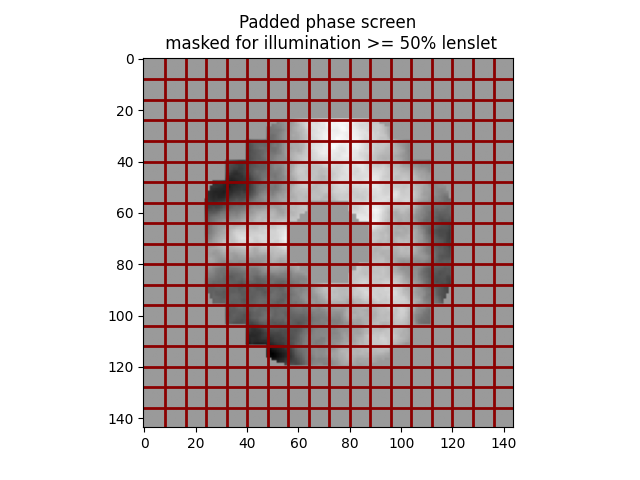

Processingtime : 243.41940879821777 ms


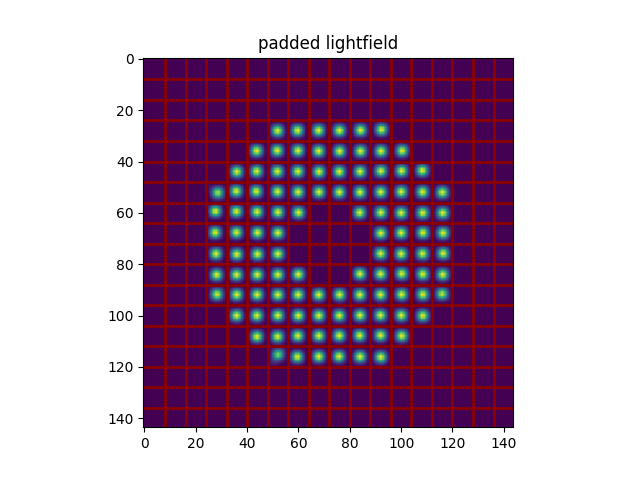

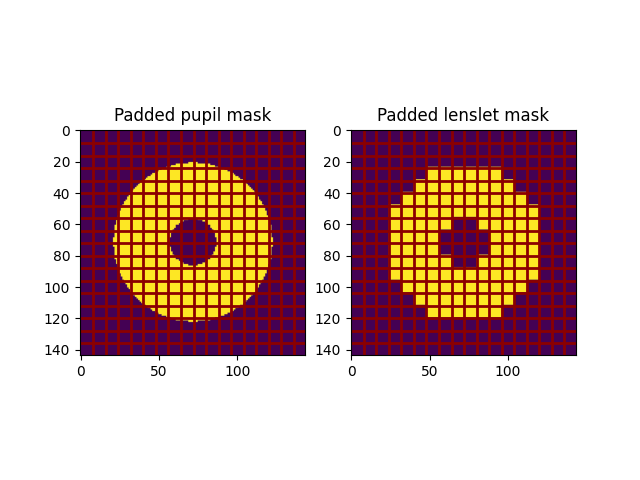

In [10]:
from ows import fouriertransform as mathft
# TODO: Focus the sub-aperture with a lens of only fft ?
# TODO: Check wether R need to be relative to the lenslet or the puppil
### 1. focussing the sub-apetures + aperture centres
focal_length = 8e-3 #[m]
N = 18
#M = N # tom implement on recrangular sub-apertures
n = int(np.ceil(dimmat/N)) # By definition, the number of lenslets must be an integer
if N%2 == 0:
    padded_dim = n*(N) # N+1 in order to have a lenslet centered on the optical axis
else:
    padded_dim = n*(N+1)

# Pad the pupil mask for illuminaiton computation
padded_mask = np.zeros((padded_dim,padded_dim),int)
padded_mask[(padded_dim-dimmat)//2:(padded_dim-dimmat)//2 + dimmat,(padded_dim-dimmat)//2:(padded_dim-dimmat)//2 + dimmat] = pupil_mask

padded_phase_screen = np.zeros_like(padded_mask,np.float64)
padded_phase_screen[(padded_dim-dimmat)//2:(padded_dim-dimmat)//2 + dimmat,(padded_dim-dimmat)//2:(padded_dim-dimmat)//2 + dimmat] = phase_screen

lenslet_mask = np.zeros_like(padded_mask)
active_lenslet_matrix = np.zeros((N,N))

ii=0
for i in range(0, padded_dim, n):
    jj=0
    for j in range(0, padded_dim, n):
        lenslet = padded_mask[i:i+n, j:j+n]
        if (lenslet.sum() >= (n*n)/2):
            lenslet_mask[i:i+n, j:j+n] = 1
            active_lenslet_matrix[ii,jj] = 1
        jj += 1
    ii +=1

plt.close(6)
plt.figure(6)
plt.subplot(1,2,1)
for i in range(1,N+1):
    x = [0, padded_dim] 
    y = [n*i, n*i] 
    plt.plot(x, y, 'darkred', linewidth=2)
for i in range(1,N+1):
    x = [n*i, n*i] 
    y = [0, padded_dim] 
    plt.plot(x, y, 'darkred', linewidth=2)
plt.imshow(padded_mask)
plt.title("Padded pupil mask")
plt.subplot(1,2,2)
for i in range(1,N+1):
    x = [0, padded_dim] 
    y = [n*i, n*i] 
    plt.plot(x, y, 'darkred', linewidth=2)
for i in range(1,N+1):
    x = [n*i, n*i] 
    y = [0, padded_dim] 
    plt.plot(x, y, 'darkred', linewidth=2)
plt.imshow(lenslet_mask)
plt.title("Padded lenslet mask")

plt.close(7)
plt.figure(7)
for i in range(1,N+1):
    x = [0, padded_dim] 
    y = [n*i, n*i] 
    plt.plot(x, y, 'darkred', linewidth=2)
for i in range(1,N+1):
    x = [n*i, n*i] 
    y = [0, padded_dim] 
    plt.plot(x, y, 'darkred', linewidth=2)
plt.imshow(padded_phase_screen*lenslet_mask,cmap="grey")
plt.title("Padded phase screen\n masked for illumination >= 50% lenslet")
plt.show()
padded_R = np.zeros_like(padded_phase_screen,np.float64)
padded_R[(padded_dim-dimmat)//2:(padded_dim-dimmat)//2 + dimmat,(padded_dim-dimmat)//2:(padded_dim-dimmat)//2 + dimmat] = R
padded_lightfield = np.zeros_like(padded_phase_screen,np.float64)

k_max = N*N


pad = 4
sub_ps = np.zeros((pad*n,pad*n))
sub_R = np.zeros_like(sub_ps)

active_lenslet_matrix_1D = active_lenslet_matrix.reshape(N*N)
Xc = np.zeros((active_lenslet_matrix_1D.shape[0]))
Yc = np.zeros_like(Xc)
k = 0
for j in range(0, padded_dim, n):
    for i in range(0, padded_dim, n):
        if int(active_lenslet_matrix_1D[k]) == 1:
            Xc[k] = i+n/2
            Yc[k] = j+n/2
            sub_ps[0:n,0:n] = padded_phase_screen[i:i+n,j:j+n]
            sub_R[0:n,0:n] = padded_R[i:i+n,j:j+n]  
            sub_sp = np.sum(sub_R)*dxp**2
            apsf = mathft.ft2(sub_R*np.exp(-1j *sub_R*sub_ps),delta=1./dxp)/sub_sp
            padded_lightfield[i:i+n,j:j+n] = np.abs(apsf[pad*n//2-n//2:pad*n//2+n//2,pad*n//2-n//2:pad*n//2+n//2])**2
        k +=1

### 2. Computing the spot centres
Xr = np.zeros_like(Xc)
Yr = np.zeros_like(Xc)
Xs = np.linspace(0 ,padded_dim-1,padded_dim)
xx, yy = np.meshgrid(Xs,Xs)

XI = xx*padded_lightfield
YI = yy*padded_lightfield
k = 0
for i in range(0, padded_dim, n):
    for j in range(0, padded_dim, n):
        if int(active_lenslet_matrix_1D[k]) == 1:
            Xr[k] = XI[i:i+n,j:j+n].sum()/padded_lightfield[i:i+n,j:j+n].sum()
            Yr[k] = YI[i:i+n,j:j+n].sum()/padded_lightfield[i:i+n,j:j+n].sum()
        k +=1

### 2. Extract the WF slopes
DwDx = ((Xr-Xc)/focal_length).reshape(N,N)
DwDy = ((Yr-Yc)/focal_length).reshape(N,N)
end = time.time()

print("Processingtime :",
      (end-start) * 10**3, "ms")

padded_lightfield = normalize(padded_lightfield)

plt.close(8)
plt.figure(8)
for i in range(1,N+1):
    x = [0, padded_dim] 
    y = [n*i, n*i] 
    plt.plot(x, y, 'darkred', linewidth=2)
for i in range(1,N+1):
    x = [n*i, n*i] 
    y = [0, padded_dim] 
    plt.plot(x, y, 'darkred', linewidth=2)
plt.imshow(padded_lightfield)
plt.title("padded lightfield")
plt.show()